In [47]:
import numpy as np
import pandas as pd
import pickle
from optimizers import startModifiedTurboOptimizer
from utils import find_closest_point

In [48]:
# load data in pandas dataframe from qsar_aquatic_toxicity.csv
data = pd.read_csv('qsar_aquatic_toxicity.csv', sep=';', header=None)

# set column names to x1, x2, ..., xn, y for length of data-1
column_names = ['x' + str(i) for i in range(1, len(data.columns))]
column_names.append('y')
data.columns = column_names

In [49]:
# check each feature if the space is discrete or continuous
discrete = []
for column in data.columns[:-1]:
    if len(data[column].unique()) < 10:
        discrete.append('int')
    else:
        discrete.append('real')

In [50]:
# Function to convert observations in a dataframe to a list of dictionaries

def get_all_observations(df):
    '''
    df is a dataframe with columns x1, x2, ..., xn and y.
    Outputs the dataframe as list of dictionaries of observations of format:
    [{X: {'x1': 0.42434, 'x2': 0.385025, 'x3': 0.359904, 'x4': 0.411092}, Y: 0.607759}, ...]
    '''
    observations = []
    for i in range(len(df)):
        observation = {}
        observation['X'] = df.iloc[i, :-1].to_dict()
        observation['Y'] = df.iloc[i, -1]
        observations.append(observation)
    return observations

In [51]:
# Get all instances from the dataframe as a list of dictionaries

observations = get_all_observations(data)

all_X_list = []
all_y_list = []

for observation in observations:
    all_X_list.append(observation['X'])
    all_y_list.append(observation['Y'])

In [52]:
# Get a random sample of 50 observations from the data to initialize the model
# This is supposed to simulate making 50 experiments with random parameters

sample = data.sample(n=50)
observations = get_all_observations(sample)

initial_X_list = []
initial_y_list = []

for observation in observations:
    initial_X_list.append(observation['X'])
    initial_y_list.append(observation['Y'])

config = {
        'x1': {'type': discrete[0], 'space': 'linear'},
        'x2': {'type': discrete[1], 'space': 'linear'},
        'x3': {'type': discrete[2], 'space': 'linear'},
        'x4': {'type': discrete[3], 'space': 'linear'},
        'x5': {'type': discrete[4], 'space': 'linear'},
        'x6': {'type': discrete[5], 'space': 'linear'},
        'x7': {'type': discrete[6], 'space': 'linear'},
        'x8': {'type': discrete[7], 'space': 'linear'}
    }

# get actual max and min range from data
for key in config.keys():
    config[key]['range'] = [data[key].min(), data[key].max()]

In [53]:
# Running the optimizer for for 15, 30, 45, 60, 75, 90 iterations
# And 10 times for each iteration cycle
# This can take a long time, so we save the results to a pickle file
# If we want to keep working with previously saved results, we can set reload to False
reload = True

In [ ]:
# We initialize the optimizer with the initial 50 observations
# After requestng a new query, we find the known point with the shortest Euclidean distances
# to the suggested next query in the full dataset of experimental results
# We then observe that closest known point with the optimizer
# This allows us to simulate the optimizer making experiments with random parameters
# and then using the results of those experiments to make better suggestions

test_iteration_cycles = [15, 30, 45, 60, 75, 90]
test_per_cycle = 10

if reload:
    results = {}

    for iteration_cycle in test_iteration_cycles:
        results[iteration_cycle] = []
        queries = []
        known_Y = []
        for i in range(test_per_cycle):
            # Start the optimizer
            turbo_optimizer = startModifiedTurboOptimizer(config, initial_X_list, initial_y_list)
            batch = []
            for j in range(iteration_cycle):
                next_query = turbo_optimizer.suggest()[0]
                queries.append(next_query)

                closest_known_point_index = find_closest_point(next_query, all_X_list)

                closest_known_X = all_X_list[closest_known_point_index]
                closest_known_Y = all_y_list[closest_known_point_index]

                known_Y.append(closest_known_Y)
                batch.append(closest_known_Y)

                turbo_optimizer.observe([closest_known_X], [-closest_known_Y])

            results[iteration_cycle].append(batch)

    # save results to a pickle file
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)

else:
    # load results from pickle file
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)

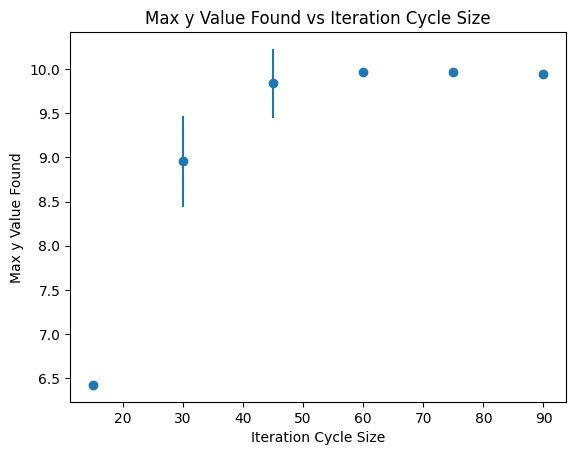

In [57]:
# Plot the mean and standard deviation of the max y value found at each iteration cycle size

import matplotlib.pyplot as plt

max_results = {}
mean_results = []
std_results = []

for iteration_cycle in results.keys():
    max_results[iteration_cycle] = []
    for batch in results[iteration_cycle]:
        max_results[iteration_cycle].append(max(batch))

for iteration_cycle in max_results.keys():
    mean_results.append(np.mean(max_results[iteration_cycle]))
    std_results.append(np.std(max_results[iteration_cycle]))

plt.errorbar(
    x = list(max_results.keys()),
    y = mean_results,
    yerr = std_results,
    fmt = 'o'
    )
plt.xlabel('Iteration Cycle Size')
plt.ylabel('Max y Value Found')
plt.title('Max y Value Found vs Iteration Cycle Size')
plt.show()

In [64]:
# write a function that takes a number and returns the rank of that number in all_y_list
# this will be used to plot the rank of the max y value found at each iteration cycle size

performance = {}

for i, c in enumerate(test_iteration_cycles):
    # find the closest value in all_y_list to y
    # return the rank of that value in all_y_list

    # format as dictionaries to use find_closest_point function
    y_dict = {'y': mean_results[i]}
    all_y_dict_list = []
    for y in all_y_list:
        all_y_dict_list.append({'y': y})

    closest_index = find_closest_point(y_dict, all_y_dict_list)

    # find the rank of that value in all_y_list by sorting all_y_list descending
    rank = sorted(all_y_list, reverse=True).index(all_y_list[closest_index])

    performance[list(max_results.keys())[i]] = (rank, round(mean_results[i], 3))

# print performance of each iteration cycle size and the rank and mean of the max y value found in 10 runs
print('Iteration Cycle Size\tRank* \tMean Max y Value Found')
for key in performance.keys():
    print('{}\t\t\t{}\t\t{}'.format(key, performance[key][0], performance[key][1]))
print('')
print('*Rank is the  rank of the point in the experimental data closest mean max y value found in 10 runs in all_y_list sorted descending')

Iteration Cycle Size	Rank* 	Mean Max y Value Found
15			73		6.424
30			8		8.955
45			1		9.839
60			1		9.965
75			1		9.965
90			1		9.945

*Rank is the  rank of the point in the experimental data closest mean max y value found in 10 runs in all_y_list sorted descending


Results:

When given 50 random initial observations from the set of 546 experimental results, the Turbo-based optimizer made 10xN (n=[15, 30, 45, 60, 75, 90]) suggestions and observed the known data point closest to the suggested point. We judge performance by the mean of the max of the closest known point to the suggested points of the 10 tests.

We can see that at 15 sequencial observations, the mean of the best suggestions would have been the 73d experimental value ranked from least highest to lowest.
Immediatly at 30 iterations per run, the performance is much better, and at 45 iterations it has already maxed out and always finds the optimal value. This is connected to that the optimizer is configured to prioritize exploration in the first 10 queries, and becomes more exploitation focused after that. 

These results indicate that using Baysean Optimization to suggest candidate molecules is a strategy worth exploring. Synthesizing molecules for toxicity testing is very expenive and time consuming, and this strategy may reduce the number of experimments to find compounds with low toxicity.